# Предсказание цены автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### План работ

 1. Загрузите и подготовьте данные.
 2. Обучите разные модели с различными гиперпараметрами.
 3. Проанализируйте скорость работы и качество моделей.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [3]:
import lightgbm as lgb
from catboost import CatBoostRegressor

In [4]:
autos_data = pd.read_csv('/datasets/autos.csv')

In [5]:
autos_data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Описательная статистика:

In [7]:
autos_data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество уникальных значений в каждом столбце:

In [8]:
autos_data.nunique(dropna=False)

DateCrawled          271174
Price                  3731
VehicleType               9
RegistrationYear        151
Gearbox                   3
Power                   712
Model                   251
Kilometer                13
RegistrationMonth        13
FuelType                  8
Brand                    40
NotRepaired               3
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

In [9]:
for column in autos_data.columns:
    print(column)
    print(autos_data[column].value_counts(dropna=False).head(15))
    print()

DateCrawled
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-04-01 19:25:23    5
2016-03-22 10:42:10    5
2016-03-26 10:51:07    5
2016-03-16 13:47:44    5
2016-03-20 16:50:22    5
2016-03-19 12:50:39    5
2016-03-28 10:48:11    5
2016-03-22 14:50:05    5
2016-03-31 18:50:16    5
2016-03-05 14:25:23    5
2016-04-02 22:54:55    5
2016-03-11 15:36:59    5
Name: DateCrawled, dtype: int64

Price
0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
3500     3792
800      3784
2000     3431
999      3364
750      3203
650      3150
4500     3053
850      2946
Name: Price, dtype: int64

VehicleType
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

RegistrationYear
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
2003    19763
20

### Выводы

В данных большое количество пропусков и данных, которые являются ошибочными. В следующем пунке мы исправим это подготовим даные для обучения.

## Исследование признаков и заполнение пропусков

Наша задача, это обучить алогоритм, способный предсказывать рыночную стоимость автомобиля, поэтому, признаки 'DataCrawled', 'DataCreated', 'LastSeen' и 'PostalCode' будут вводить в заблуждение алгоритм. Также удалим 'NumbersOfPictures', так как весь столбец состоит из 0.

In [10]:
preprocessing_autos_data = autos_data.copy()
preprocessing_dates = preprocessing_autos_data[['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode']]
preprocessing_autos_data = preprocessing_autos_data.drop(['DateCrawled', 'DateCreated', 'LastSeen','PostalCode'], axis=1)
preprocessing_autos_data = preprocessing_autos_data.drop(['NumberOfPictures'], axis=1)
preprocessing_autos_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [11]:
preprocessing_dates.head()

,DateCrawled,DateCreated,LastSeen,PostalCode
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57,70435
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50,66954
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46,90480
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17,91074
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21,60437


In [12]:
preprocessing_dates['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: object

Рассмативать автомобили, старше 50 лет,нет смысла, так как они уже переходят в категорию "раритет" и цена на них совершенно не предсказуема.

Также, мы знаем, что последняя дата скачивания анкеты из базы 2016-04-07 14:36:58. Это значит, что дата регистрации автомобиле не может быть больше апреля 2016 года. Значит данные за превышающий период являются ошибочными.

Таким образом, я предлагаю рассмативать данные в период с 01.01.1966 по 07.04.2016.

In [13]:
preprocessing_autos_data = (preprocessing_autos_data[(preprocessing_autos_data['RegistrationYear'] >= 1966)
                                                & (preprocessing_autos_data['RegistrationYear'] <= 2016)]
                          .drop(preprocessing_autos_data[(preprocessing_autos_data['RegistrationYear'] == 2016)
                                                       & (preprocessing_autos_data['RegistrationMonth'] >4)]
                                .index))

In [14]:
preprocessing_autos_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Избавившись от очевидных лишних данных, можно обратить внимание на целевой признак. В нем присутсвует большое количество нулевых значений, а, как известно, цена автомобиля не может равняться 0. Я предлагаю поступить так: мы их уберем из таблицы, однако не удалим, а испозуем в самом конце, предсказав их значения.

In [15]:
zero_price_cars = preprocessing_autos_data[preprocessing_autos_data['Price']==0]
preprocessing_autos_data = preprocessing_autos_data.drop(preprocessing_autos_data[preprocessing_autos_data['Price']==0].index)
zero_price_cars

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
154,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


Рассмотрим корреляцию цены автомобиля от остальных признаков:

In [16]:
preprocessing_autos_data.corr()['Price']

Price                1.000000
RegistrationYear     0.503354
Power                0.165347
Kilometer           -0.354734
RegistrationMonth    0.099289
Name: Price, dtype: float64

Сильнее всего на цену авто влияют год регистрации и пробег.

Но сами значения показывают слабо-умеренную связь.  

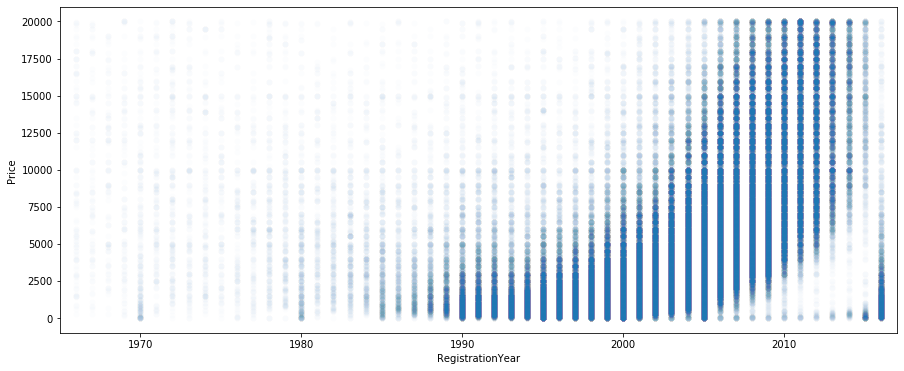

In [17]:
plt.figure(figsize=(15,6))
plt.xlim(1965,2017)
sns.scatterplot(y='Price', x='RegistrationYear', data=preprocessing_autos_data, alpha=0.01)

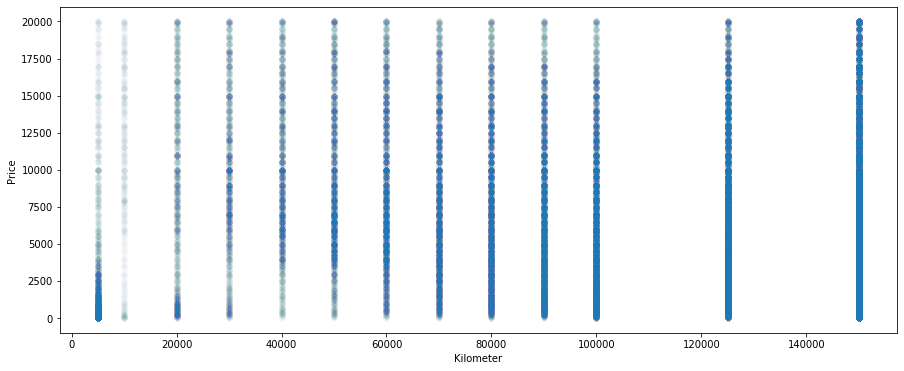

In [18]:
plt.figure(figsize=(15,6))
# plt.xlim(1965,2017)
sns.scatterplot(y='Price', x='Kilometer', data=preprocessing_autos_data, alpha=0.006)

___

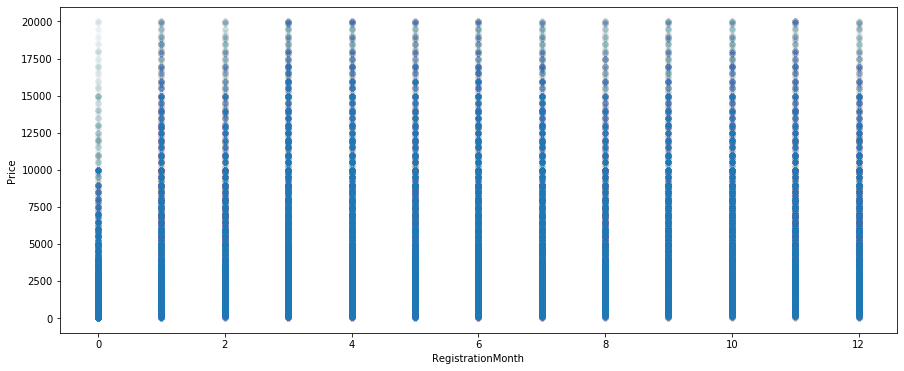

In [19]:
plt.figure(figsize=(15,6))
sns.scatterplot(y='Price', x='RegistrationMonth', data=preprocessing_autos_data, alpha=0.006)

Из последнего графика можно сделать вывод, что месяц регистрации не влияет на цену авто.

In [20]:
preprocessing_autos_data = preprocessing_autos_data.drop('RegistrationMonth', axis=1)

Рассмотрим мощность автомобилей.

(-2, 252)

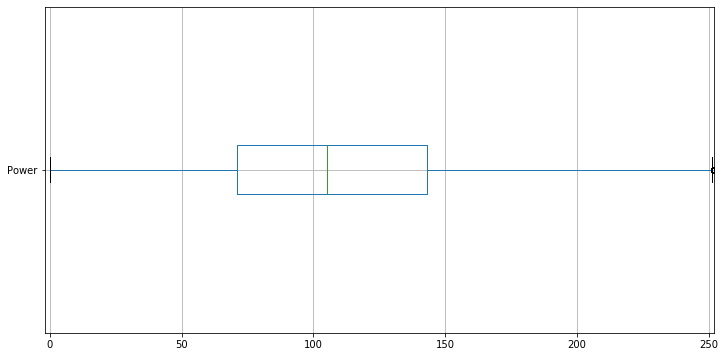

In [22]:
plt.figure(figsize=(12,6))
preprocessing_autos_data.boxplot(column='Power', vert=False)
plt.xlim(-2,252)

In [23]:
preprocessing_autos_data['Power'].describe()

count    324615.000000
mean        112.393762
std         183.326778
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [24]:
preprocessing_autos_data = preprocessing_autos_data.drop(preprocessing_autos_data[preprocessing_autos_data['Power'] > 251].index)

In [25]:
preprocessing_autos_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Далее я предлагаю разобраться с категориальными признаками. В них обязательно должны быть заполненны пропуски.

In [26]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
preprocessing_autos_data = pd.DataFrame(imputer.fit_transform(preprocessing_autos_data.values), 
                                        index=preprocessing_autos_data.index, 
                                        columns=preprocessing_autos_data.columns)

In [29]:
preprocessing_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317643 entries, 0 to 354368
Data columns (total 10 columns):
Price               317643 non-null int32
VehicleType         317643 non-null object
RegistrationYear    317643 non-null object
Gearbox             317643 non-null object
Power               317643 non-null int32
Model               317643 non-null object
Kilometer           317643 non-null int32
FuelType            317643 non-null object
Brand               317643 non-null object
NotRepaired         317643 non-null object
dtypes: int32(3), object(7)
memory usage: 23.0+ MB


In [30]:
preprocessing_autos_data[['Price', 'Power', 'Kilometer']] = preprocessing_autos_data[['Price', 'Power', 'Kilometer']].astype('int32')

In [31]:
preprocessing_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317643 entries, 0 to 354368
Data columns (total 10 columns):
Price               317643 non-null int32
VehicleType         317643 non-null object
RegistrationYear    317643 non-null object
Gearbox             317643 non-null object
Power               317643 non-null int32
Model               317643 non-null object
Kilometer           317643 non-null int32
FuelType            317643 non-null object
Brand               317643 non-null object
NotRepaired         317643 non-null object
dtypes: int32(3), object(7)
memory usage: 23.0+ MB


In [32]:
for column in preprocessing_autos_data.columns:
    print(column)
    print(preprocessing_autos_data[column].value_counts(dropna=False).head(15))
    print()

Price
500     5312
1500    4970
1000    4250
1200    4244
2500    4149
3500    3560
600     3534
800     3478
2000    3183
999     3138
750     2954
650     2918
4500    2837
2200    2730
850     2723
Name: Price, dtype: int64

VehicleType
sedan          86187
small          77825
wagon          62613
bus            28268
convertible    19253
other          18221
coupe          14357
suv            10919
Name: VehicleType, dtype: int64

RegistrationYear
2000    22676
1999    21648
2005    20670
2001    19302
2003    19046
2006    18947
2004    18809
2002    18316
1998    16974
2007    16367
2008    14724
2009    14165
1997    13843
2010    10534
1996    10226
Name: RegistrationYear, dtype: int64

Gearbox
manual    245421
auto       57313
other      14909
Name: Gearbox, dtype: int64

Power
0      31487
75     21695
60     14475
150    13634
101    12227
140    12222
90     11554
116    11263
105     9759
170     9631
125     6402
136     6377
102     6030
163     5859
54      5342
Name:

### Выводы

В данных были заполнены пропуски и удалены ошибочные данные:
 - в финальный набор данных были взяты автомобили не старше 1966 и не моложе 2016, так как данные были скачаны в 2016 году;
 - удаленны автомобили, мощность двиателя которох выше 251;
 - удалены даты из датасета.

# 2. Обучение моделей

Для начала выделим целевые признаки и разделим набор данных на 3 выборки (train, valid, test). 

In [33]:
autos_target = preprocessing_autos_data['Price']
autos_features = preprocessing_autos_data.drop('Price', axis=1)

In [34]:
autos_target.head()

0      480
1    18300
2     9800
3     1500
4     3600
Name: Price, dtype: int32

In [35]:
autos_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,other,1993,manual,0,golf,150000,petrol,volkswagen,other
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,other
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [36]:
autos_features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [37]:
autos_features['NotRepaired'].value_counts(dropna=False)

no       228877
other     56931
yes       31835
Name: NotRepaired, dtype: int64

In [38]:
autos_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317643 entries, 0 to 354368
Data columns (total 9 columns):
VehicleType         317643 non-null object
RegistrationYear    317643 non-null object
Gearbox             317643 non-null object
Power               317643 non-null int32
Model               317643 non-null object
Kilometer           317643 non-null int32
FuelType            317643 non-null object
Brand               317643 non-null object
NotRepaired         317643 non-null object
dtypes: int32(2), object(7)
memory usage: 21.8+ MB


Теперь нужно скалировать неперерывные переменные.

In [40]:
sc = StandardScaler()
autos_features_scal = autos_features.copy()
autos_features_scal[[ 'Power', 'Kilometer']] = sc.fit_transform(autos_features[[ 'Power', 'Kilometer']])
autos_features_scal

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,other,1993,manual,-1.885114,golf,0.582766,petrol,volkswagen,other
1,coupe,2011,manual,1.527036,other,-0.083448,gasoline,audi,yes
2,suv,2004,auto,1.042152,grand,-0.083448,gasoline,jeep,other
3,small,2001,manual,-0.538212,golf,0.582766,petrol,volkswagen,no
4,small,2008,manual,-0.645964,fabia,-1.016147,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
354363,bus,2000,manual,-1.885114,zafira,0.582766,petrol,opel,no
354365,other,2005,other,-1.885114,other,-2.881544,other,sonstige_autos,other
354366,convertible,2000,auto,-0.071287,fortwo,-0.083448,petrol,smart,no
354367,bus,1996,manual,-0.053328,transporter,0.582766,gasoline,volkswagen,no


Далее разбиение модел на тренировочную и тестовую выборки. Валидационой выборки нет, так как подбор параметров происходит с помощью GridSearchCV, а он обучает на всем датасете методом кросс-валидации. (Для LightGBM я не применил, только из-за того, что это занимает кучу времени.)

In [41]:
train_features, test_features, train_target, test_target = train_test_split(autos_features_scal, 
                                                                              autos_target, 
                                                                              test_size=0.2, 
                                                                              random_state=124)

Для проверки на адекватность моделей, обучим простую модель, которая предсказывает средее значение для всех результатов.

In [42]:
dummy_model = DummyRegressor()
dummy_model.fit(train_features, train_target)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [43]:
dummy_prediction = dummy_model.predict(test_features)

In [44]:
dummy_rmse =np.sqrt(mean_squared_error(dummy_prediction, test_target))

In [45]:
dummy_rmse

4415.912967838247

## CatBoost

In [46]:
train_features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
337974,small,2004,manual,-0.807593,punto,-0.083448,petrol,fiat,no
224380,bus,2010,manual,0.629102,sharan,-1.016147,gasoline,volkswagen,no
128394,wagon,2005,manual,0.629102,octavia,0.582766,gasoline,skoda,no
342431,sedan,2004,manual,-0.538212,golf,-3.281272,petrol,volkswagen,no
192397,bus,2008,manual,0.000548,roomster,-0.083448,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...
55171,bus,2006,manual,-0.304749,modus,-1.549117,petrol,renault,no
298754,sedan,2003,auto,0.808689,e_klasse,0.582766,gasoline,mercedes_benz,no
229662,wagon,2003,manual,0.467474,passat,0.582766,gasoline,volkswagen,no
100602,sedan,2003,manual,-0.376584,other,-0.083448,petrol,hyundai,no


Создаем список с категориальными данными.

In [76]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

---

задаем парамеры для GridSearchCV.

In [94]:
grid_parameters = {'learning_rate':[0.3],'iterations' : [150,200,250], 'depth' : [10,12]}
# я потратил на это целый день, так что сразу поставим параметры, которые нам показал best_params_
grid_parameters = {'learning_rate':[0.3],'iterations' : [250], 'depth' : [12]}

In [96]:
cbr_model = GridSearchCV(estimator = CatBoostRegressor(loss_function='RMSE', random_state=12),
                         param_grid=grid_parameters, 
                         cv=3, 
                         verbose=1, 
                         n_jobs=-1)

In [105]:
%%time
cbr_model.fit(autos_features_norm, autos_target, cat_features =cat_features, verbose=10)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 3547.1887165	total: 598ms	remaining: 1m 29s
10:	learn: 1840.1986710	total: 5.79s	remaining: 1m 13s
20:	learn: 1747.9844723	total: 10.9s	remaining: 1m 6s
30:	learn: 1682.0916680	total: 16s	remaining: 1m 1s
40:	learn: 1648.0458576	total: 21.4s	remaining: 56.8s
50:	learn: 1616.3583985	total: 26.5s	remaining: 51.4s
60:	learn: 1590.5815157	total: 31.6s	remaining: 46.2s
70:	learn: 1574.8762178	total: 36.6s	remaining: 40.8s
80:	learn: 1559.4021926	total: 41.8s	remaining: 35.6s
90:	learn: 1544.6085994	total: 46.9s	remaining: 30.4s
100:	learn: 1533.5057348	total: 52s	remaining: 25.2s
110:	learn: 1523.7625794	total: 57.1s	remaining: 20.1s
120:	learn: 1516.1155528	total: 1m 2s	remaining: 14.9s
130:	learn: 1504.4942459	total: 1m 7s	remaining: 9.77s
140:	learn: 1495.9997460	total: 1m 12s	remaining: 4.63s
149:	learn: 1488.0239340	total: 1m 17s	remaining: 0us
0:	learn: 3547.7622950	total: 537ms	remaining: 1m 20s
10:	learn: 1849.9221282	total: 5.74s	remaining: 1m 12s
20:	learn: 1738.6456804	

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 116.4min finished


0:	learn: 3450.6303979	total: 3.21s	remaining: 13m 19s
10:	learn: 1722.2555691	total: 36.1s	remaining: 13m 4s
20:	learn: 1606.0373016	total: 1m 11s	remaining: 12m 56s
30:	learn: 1551.8156038	total: 1m 47s	remaining: 12m 38s
40:	learn: 1519.8719801	total: 2m 25s	remaining: 12m 21s
50:	learn: 1487.9869304	total: 3m 2s	remaining: 11m 51s
60:	learn: 1462.4628444	total: 3m 39s	remaining: 11m 20s
70:	learn: 1442.9128869	total: 4m 16s	remaining: 10m 47s
80:	learn: 1424.9066842	total: 4m 55s	remaining: 10m 17s
90:	learn: 1407.4795407	total: 5m 36s	remaining: 9m 48s
100:	learn: 1390.8973506	total: 6m 14s	remaining: 9m 11s
110:	learn: 1376.7478970	total: 6m 51s	remaining: 8m 35s
120:	learn: 1362.0855315	total: 7m 32s	remaining: 8m 2s
130:	learn: 1349.7773743	total: 8m 12s	remaining: 7m 27s
140:	learn: 1338.2676825	total: 8m 50s	remaining: 6m 50s
150:	learn: 1328.9248910	total: 9m 29s	remaining: 6m 13s
160:	learn: 1319.3935335	total: 10m 9s	remaining: 5m 36s
170:	learn: 1310.0174217	total: 10m 47

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f202d9ee0d0>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [10, 12], 'iterations': [150, 200, 250],
                         'learning_rate': [0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [109]:
cbr_model.cv_results_

{'mean_fit_time': array([ 81.18771855, 391.21521529, 495.22890019, 114.6127487 ,
        549.79185224, 688.14686219]),
 'std_fit_time': array([0.60102203, 2.96897232, 0.73403813, 0.31114283, 2.04452768,
        1.75949739]),
 'mean_score_time': array([0.50182048, 1.53660782, 1.68216228, 0.63756863, 1.57159964,
        1.97493474]),
 'std_score_time': array([0.02827231, 0.02739788, 0.07210049, 0.02477285, 0.04871116,
        0.10440573]),
 'param_depth': masked_array(data=[10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_iterations': masked_array(data=[150, 200, 250, 150, 200, 250],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params

Смотрим, при каких гипперпараметрах было достигнуто наименьшее значение функции потерь.

In [97]:
cbr_model.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

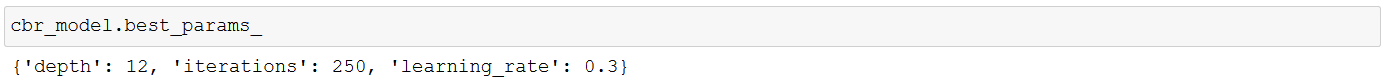

Удаляем модель для очистки памяти.

In [ ]:
del cbr_model

---

Обучаем финальную модель и находим предсказания.

In [77]:
%%time
cbr = CatBoostRegressor(loss_function='RMSE', learning_rate=0.3, iterations=250, depth=12)
cbr.fit(train_features, train_target, cat_features =cat_features, verbose=10)

0:	learn: 3455.3474535	total: 3.23s	remaining: 13m 23s
10:	learn: 1645.9649955	total: 28.7s	remaining: 10m 24s
20:	learn: 1537.9334840	total: 59s	remaining: 10m 43s
30:	learn: 1482.3121335	total: 1m 30s	remaining: 10m 40s
40:	learn: 1435.5279647	total: 1m 58s	remaining: 10m 6s
50:	learn: 1395.4194871	total: 2m 27s	remaining: 9m 35s
60:	learn: 1371.0742225	total: 2m 58s	remaining: 9m 14s
70:	learn: 1350.5035064	total: 3m 29s	remaining: 8m 49s
80:	learn: 1328.6670969	total: 4m	remaining: 8m 22s
90:	learn: 1312.3259111	total: 4m 32s	remaining: 7m 56s
100:	learn: 1298.7069310	total: 5m 3s	remaining: 7m 28s
110:	learn: 1280.5752000	total: 5m 35s	remaining: 7m
120:	learn: 1262.5616802	total: 6m 8s	remaining: 6m 32s
130:	learn: 1248.7888879	total: 6m 40s	remaining: 6m 4s
140:	learn: 1239.5916447	total: 7m 13s	remaining: 5m 35s
150:	learn: 1230.5961975	total: 7m 45s	remaining: 5m 5s
160:	learn: 1221.8770093	total: 8m 17s	remaining: 4m 35s
170:	learn: 1213.5318764	total: 8m 50s	remaining: 4m 5s

In [78]:
%%time
prediction = cbr.predict(test_features)

CPU times: user 968 ms, sys: 55.2 ms, total: 1.02 s
Wall time: 978 ms


In [79]:
cat_boost_mse = np.sqrt(mean_squared_error(prediction, test_target))

In [80]:
cat_boost_mse

1508.9186080828624

In [81]:
print('разница между средней моделью и CatBoost: ',dummy_rmse - cat_boost_mse)

разница между средней моделью и CatBoost:  2906.9943597553847


In [82]:
del cbr

SyntaxError: invalid syntax (<ipython-input-82-7e6bed565c2f>, line 1)

## LightGBM

Для начала закодируем порядковым кодированием категориальные признаки.

In [47]:
def oe_transform(features):
    oe = OrdinalEncoder()
    oe_features = features.copy()
    categ_features = features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]
    oe.fit(categ_features)
    oe_categ_features = pd.DataFrame(oe.transform(categ_features),
                                columns = categ_features.columns,
                                index=oe_features.index)
    oe_features = oe_features.drop(categ_features.columns,axis=1)
    oe_features = pd.concat([oe_features, oe_categ_features], axis=1)
    oe_features['RegistrationYear'] = pd.to_numeric(oe_features['RegistrationYear'])
    return oe_features

OneHotEncoder тут не подошел.

In [50]:
oe_train_features = oe_transform(train_features)
oe_test_features = oe_transform(test_features)

In [51]:
oe_train_features

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
337974,2004,-0.807593,-0.083448,5.0,1.0,176.0,6.0,9.0,0.0
224380,2010,0.629102,-1.016147,0.0,1.0,203.0,2.0,38.0,0.0
128394,2005,0.629102,0.582766,7.0,1.0,163.0,2.0,31.0,0.0
342431,2004,-0.538212,-3.281272,4.0,1.0,116.0,6.0,38.0,0.0
192397,2008,0.000548,-0.083448,0.0,1.0,188.0,6.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...
55171,2006,-0.304749,-1.549117,0.0,1.0,153.0,6.0,27.0,0.0
298754,2003,0.808689,0.582766,4.0,0.0,95.0,2.0,20.0,0.0
229662,2003,0.467474,0.582766,7.0,1.0,170.0,2.0,38.0,0.0
100602,2003,-0.376584,-0.083448,4.0,1.0,166.0,6.0,12.0,0.0


In [60]:
d_train = lgb.Dataset(oe_train_features, label=train_target)

Задаем параметры для модели.

In [52]:
params = {}
params['learning_rate'] = 0.3
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['feature_fraction'] = 0.8
params['categorical_features'] = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
params['max_depth'] = 12
params

{'learning_rate': 0.3,
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'feature_fraction': 0.8,
 'categorical_features': ['VehicleType',
  'Gearbox',
  'Model',
  'FuelType',
  'Brand',
  'NotRepaired'],
 'max_depth': 12}

Обучение самой модели.

In [68]:
%%time
model = lgb.train(params, d_train, 250)

CPU times: user 13.2 s, sys: 79.5 ms, total: 13.3 s
Wall time: 13.4 s


In [69]:
oe_test_features

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
124711,2002,-0.663923,0.582766,7.0,1.0,81.0,2.0,30.0,0.0
101170,2001,-1.885114,0.582766,5.0,1.0,126.0,6.0,10.0,1.0
60514,2009,0.000548,-0.083448,7.0,1.0,101.0,6.0,31.0,2.0
63617,1992,-0.484336,0.582766,0.0,1.0,218.0,2.0,38.0,0.0
33815,2001,-1.885114,-0.749661,4.0,1.0,134.0,6.0,27.0,1.0
...,...,...,...,...,...,...,...,...,...
285815,2001,0.305846,0.582766,7.0,1.0,223.0,6.0,39.0,0.0
71146,2007,1.167863,0.582766,7.0,1.0,168.0,2.0,38.0,0.0
25600,2004,0.808689,0.582766,7.0,0.0,11.0,2.0,2.0,0.0
93159,2008,1.167863,-0.749661,7.0,1.0,11.0,6.0,2.0,0.0


In [72]:
%%time
lgb_prediction = model.predict(oe_test_features)

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.46 s


In [73]:
lgb_prediction

array([ 1515.36145219,   594.30887833,  4492.21777756, ...,
        4559.8048464 , 12193.66512657,  1005.11415304])

In [94]:
lgb_mse = np.sqrt(mean_squared_error(test_target,lgb_prediction))
lgb_mse

1630.9007359618427

In [112]:
print('разница между средней моделью и CatBoost: ',dummy_rmse - lgb_mse)

разница между средней моделью и CatBoost:  2785.0122318764043


In [96]:
del model

In [92]:
algorithms_speed = pd.DataFrame({'training_speed_seconds' : [795, 13.5], 'prediction_speed_seconds' : [0.978, 1.46]}, index=['CatBoost', 'LightGBM'])

# 3. Анализ моделей

В результате работы алгоритмов, у меня получились следующие рзультаты:

In [93]:
algorithms_speed

,training_speed_seconds,prediction_speed_seconds
CatBoost,795.0,0.978
LightGBM,13.5,1.460


Здесь можно наблюдать огромный разрыв в скорости обучения. Возможно, причиной тому послужило то, что я не очень верно настроил гиппер параметры. Однако самое важно, а именно время предсказания в данном проекте у CatBoost выше в полтора раза, а это очень важно, так как клиент ждать не будет. Я сделал этот вывод на примеры открытия веб-страницы (если страница грузится дольше 4 секунд, то больше 50% клиентов "отваливаются").

In [113]:
pd.DataFrame({'CatBoost' : [cat_boost_mse], 'LightGBM' : [lgb_mse], 'Dummy_Model': [dummy_rmse] }, index=['RMSE'])

,CatBoost,LightGBM,Dummy_Model
RMSE,1508.918608,1630.900736,4415.912968


Также, наиболее лучшего результата RMSE мне удалось достичь с помощью алгоритма CatBoost. Оба алгоритма значительно лучше средней модели.

Я бы рекомендовал CatBoost для комерчиского проекта такого, как интернет магазин.